In [1]:
import psi4

psi4.set_options({"reference" : "uhf"})

import CADMium as cad
import numpy as np
import matplotlib.pyplot as plt

In [3]:
h2p = psi4.geometry("""
1 2
H 0.0 0.0 -1.0
H 0.0 0.0  1.0
units bohr
symmetry c1
noreorient
""")

e, wfn = psi4.energy("ccsd/aug-cc-pvqz", return_wfn=True)

In [4]:
#Get grid from CADMIUM
a = 2.0
NP = 7
NM = [4,4]
L = np.arccosh(12/a)
loc = np.array(range(-4,5)) #Stencil outline
grid = cad.Psgrid(NP, NM, a, L, loc)
grid.initialize()

 Constructing integration weights ... 

 Building finite difference opperators ... 

 Factorizing Laplacian ... 

 Done


In [5]:
y = grid.Y
z = grid.Z
x = np.zeros_like(y)
npoints = x.shape[0]

#Build PSI4 GRID
epsilon = psi4.core.get_global_option("CUBIC_BASIS_TOLERANCE")
basis   = wfn.basisset()
extens  = psi4.core.BasisExtents(basis, epsilon) 

x = psi4.core.Vector.from_array(x)
y = psi4.core.Vector.from_array(y)
z = psi4.core.Vector.from_array(z)
block = psi4.core.BlockOPoints(x,y,z,x, extens)

max_functions = 0 if 0 > len(block.functions_local_to_global()) else len(block.functions_local_to_global())

points = psi4.core.RKSFunctions(basis, int(npoints), int(max_functions))
points.set_ansatz(0)
points.set_pointers(wfn.Da())
points.compute_points(block)
out_density = points.point_values()["RHO_A"].np

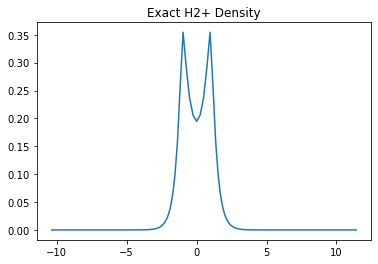

In [25]:
x, y_tar = grid.axis_plot(out_density)
plt.title("Exact H2+ Density")
plt.plot(x,y_tar)

In [37]:
#Set up a CADMium inversion algorithm

a   = 2.0
Za  = 1
Zb  = 1

pol = 2

Nma = [[1]]
Nmb = [[1]]
Nmo  = [[1,1]]

Na  = [[0.5]]
Nb  = [[0.5]]
Nm   = [[1,1]]

nua = 1.0
nub = 1.0

optPartition = {"Fractional" : True}
optInversion = {"invert_type" : "wuyang", 
                "DISP" : True}

#Set up partition object for initial guess
part = cad.Partition( grid, Za, Zb, pol, Nma, Na, nua, Nmb, Nb, nub, optPartition)

#Set up solver for inversion 
P    = cad.Pssolver( grid, Nmo, Nm )
# part.inverter = cad.Inverter(grid, P ,optInversion)
part.optPartition["ISOLATED"] = True
part.scf()

target_density = out_density

phi0, e0, v0 = part.initialguessinvert(ispin=0) 
WY = cad.Inverter(grid, P, optInversion)

_, _ = WY.invert( target_density, v0, phi0, e0 )





# part.optPartition["ISOLATED"] = False
# part.scf()

/mnt/c/Users/victo/Dropbox/PHD/Cadmium/CADMium/CADMium/partition/partition.py:317: RuntimeWarning: invalid value encountered in true_divide
  self.KSa.Q = self.KSa.scale * self.KSa.n / self.nf
/mnt/c/Users/victo/Dropbox/PHD/Cadmium/CADMium/CADMium/partition/partition.py:318: RuntimeWarning: invalid value encountered in true_divide
  self.KSb.Q = self.KSb.scale * self.KSb.n / self.nf
/mnt/c/Users/victo/Dropbox/PHD/Cadmium/CADMium/CADMium/partition/scf.py:172: RuntimeWarning: invalid value encountered in true_divide
  dif_nf = np.max(self.grid.integrate(np.abs(self.nf-old_nf)) / self.grid.integrate(np.abs(self.nf)))


In [41]:
part.

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

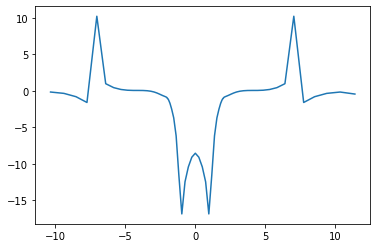

In [40]:
x, y = grid.axis_plot(WY.vs[:,0])
plt.plot(x,y)

In [27]:
ks = cad.Kohnsham(grid, Za, Zb, pol, Nmo, Nm, {})
ks.scf({})
# vs = WY.vs[:,0]
# ks.set_veff_external(vs)
# n_inv = ks.calc_density()

 iter    Total Energy     HOMO Eigenvalue         Res       

----------------------------------------------------------- 

   1         -1.035          -0.231            1.0
   2         -0.994          -0.253            0.04947998321252075
   3         -0.977          -0.262            0.01975328577380907
   4         -0.970          -0.265            0.007905316655149099
   5         -0.967          -0.267            0.003185285323629025
   6         -0.966          -0.267            0.001298787718620433
   7         -0.966          -0.268            0.0005360354528077051
   8         -0.966          -0.268            0.00022492189251366104
   9         -0.966          -0.268            9.711469130751837e-05
   10         -0.966          -0.268            4.338297957692595e-05
   11         -0.966          -0.268            2.0416947449076614e-05
   12         -0.966          -0.268            9.931319738770498e-06


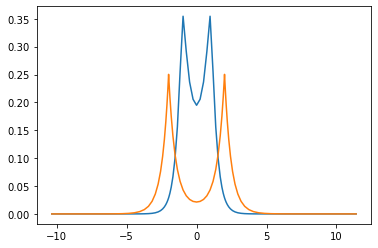

In [26]:
x, y_inv = grid.axis_plot(n_inv[:,0] + n_inv[:,1])
plt.plot(x,y_tar)
plt.plot(x, y_inv)

In [ ]:
functional = psi4.proc.dft.build_superfunctional_from_dictionary("svwn", )
vpot = psi4.core.VBase.build(basis, "svwn", "UV")

In [ ]:
block